In [1]:
from numba.pycc import CC
from photon_xy import *
import numpy as np
from numba import typed, types
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from plot import *
from numpy import genfromtxt
from numba.cuda.random import init_xoroshiro128p_states
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib import cm
from scipy import optimize
from tqdm.notebook import trange, tqdm
import time
import os
%matplotlib inline
%load_ext autoreload
%autoreload 2

def fit_func(x, const, a, b, c, d):
    return np.power(x, 3) * d + np.power(x, 2) * c + np.power(x, 2) * b + x * a + const


def make_dir(dir_name):
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)


gridDim = 1
blockDim = 64
dim = gridDim * blockDim
all_adj_dist = []
all_collected = []
all_amps = []
all_modes = []
mode = 1.0
iters = 3 * 16
iters = 50
NNxy = 500
NNr = int(NNxy / 2)
NNz = int(NNxy / 2)
# degree_divs = 64
degree_divs = 64
n_steps = 20
n_sims = 1
timers = []
dataset_path = 'data/Linear 7'

np.random.seed(4)
s1 = genfromtxt(f's1_pm_{degree_divs}.txt', delimiter=',')
s2 = genfromtxt(f's2_pm_{degree_divs}.txt', delimiter=',')
m11 = genfromtxt(f'm11_pm_{degree_divs}.txt', delimiter=',')
m12 = genfromtxt(f'm12_pm_{degree_divs}.txt', delimiter=',')
temp = 1j * s1[:, 2]
temp += s1[:, 1]
s1 = temp
temp = 1j * s2[:, 2]
temp += s2[:, 1]
s2 = temp
m11 = m11[:, 1]
m12 = m12[:, 1]

s1 = np.ascontiguousarray(s1)
s2 = np.ascontiguousarray(s2)
m11 = np.ascontiguousarray(m11)
m12 = np.ascontiguousarray(m12)
cuda.pinned(s1)
cuda.pinned(s2)
cuda.pinned(m11)
cuda.pinned(m12)

co_xy_all = np.zeros((dim, NNxy, NNxy,4), dtype=np.float32)
reflection_all = np.zeros((dim), dtype=np.float32)
zstokes_all = np.zeros((dim, NNz, 3), dtype=np.float32)

ctr = 0
ctr_trad = 0
ctr_cross = 0

make_dir(dataset_path)

make_dir(os.path.join(dataset_path, 'reflection'))
make_dir(os.path.join(dataset_path, 'zstokes'))

incident_degrees = [10, 50, 80, 85, 89]
for i in range(n_sims):
    n = 1.33
    print(f'####SIMULATION {i + 1}######')
    # incident_degree=incident_degrees[i]
    incident_degree = 0
    for j in trange(iters, desc='1st loop'):
        time1 = time.time()
        mode = i % 3
        mode = 3
        random_nums = np.random.rand(dim, n_steps * 20)
        d_jones = cuda.to_device(np.zeros((dim, 4), dtype=np.complex64))
        d_jones_partial = cuda.to_device(np.zeros((dim, 4), dtype=np.complex64))
        d_U = cuda.to_device(np.zeros((dim, 3), dtype=np.float32))
        d_W = cuda.to_device(np.zeros(dim, dtype=np.float32))
        d_mu_as = cuda.to_device(np.ones(dim, dtype=np.float32) * 0)
        d_mu_ss = cuda.to_device(np.ones(dim, dtype=np.float32) * np.float(100))
        d_scat_events = cuda.to_device(np.zeros(dim, dtype=np.float32))
        # d_position = cuda.to_device(np.zeros((NNxy, 3), dtype=np.float32))
        d_random_nums = cuda.to_device(random_nums)
        d_reflection = cuda.to_device(np.zeros((dim, 2), dtype=np.float32))
        d_zstokes = cuda.to_device(np.zeros((dim, NNz, 3), dtype=np.float32))  # co\incoh cross\cross
        d_co_xy = cuda.to_device(np.zeros((dim, NNxy, NNxy,4), dtype=np.float32))
        seed = j

        process_steps_linear[gridDim, blockDim](seed, incident_degree, n, d_reflection, d_zstokes, d_random_nums, d_U,
                                                d_W, d_jones, d_mu_as, d_mu_ss, d_scat_events, d_jones_partial,  s1, s2, m11, m12,d_co_xy)

        # position = d_position.copy_to_host()

        reflections = d_reflection.copy_to_host()
        zstokes = d_zstokes.copy_to_host()
        co_xy=d_co_xy.copy_to_host()
        
        # co_xy[co_xy[:,:,:,3]==0]=1
        # co_xy[:,:,:,0]/=co_xy[:,:,:,3]
        # co_xy[:,:,:,1]/=co_xy[:,:,:,3]
        # co_xy[:,:,:,2]/=co_xy[:,:,:,3]
        co_xy_all+=co_xy
        reflections[reflections[:, 0] == 0] = 1
        reflection_all += reflections[:, 1] / reflections[:, 0]
        zstokes_all[:, :, 0] += zstokes[:, :, 0]/ reflections[:, 0, np.newaxis]
        zstokes_all[:, :, 1] += zstokes[:, :, 1]/ reflections[:, 0, np.newaxis]       
        zstokes_all[:, :, 2] += zstokes[:, :, 2]/ reflections[:, 0, np.newaxis]

        time2 = time.time()
        timers.append(time2 - time1)
        # print(j)

    # vars = [np.mean(reflection_all,axis=0), np.mean(zstokes_all,axis=0)]
    # folders = ['reflection', 'zstokes']
    # var_names = [f'reflection_{incident_degree}.npy', f'zstokes_{incident_degree}.npy']
    # full_paths = []
    # for i in range(2):
    #     full_paths.append(os.path.join(dataset_path, folders[i], var_names[i]))
    # i = 0
    # for var, path in zip(vars, full_paths):
    #     np.save(path, var)
    #     print('saveing', folders[i])
    #     i += 1
    # with open(os.path.join(dataset_path, 'params.txt'), 'a') as f:
    #     f.writelines(f'{i},{n}\n')


####SIMULATION 1######



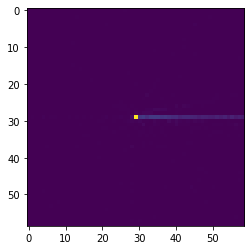

In [3]:
import matplotlib.pyplot as plt


window=30
x=np.mean(co_xy_all,axis=0)[250-window+1:250+window,250-window+1:250+window,0]
x[0,0]=0
# x[NNxy-1,NNxy-1]=0
# x[NNxy-2,NNxy-2]=0
# 
x=x/x.max()
x[x==1]=0.5
x=(x-x.mean())/x.std()
x=x/x.max()
plt.imshow(x)
# plt.imshow(x[3:-3,3:-3])
plt.show()


C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


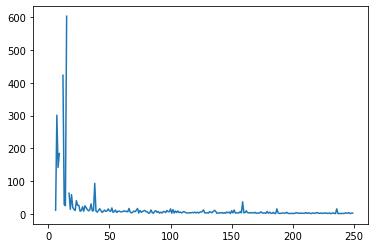

In [5]:
plt.plot(np.sum(zstokes_all[:,:,2],axis=0)/(np.sum(zstokes_all[:,:,1],axis=0)))
plt.show()


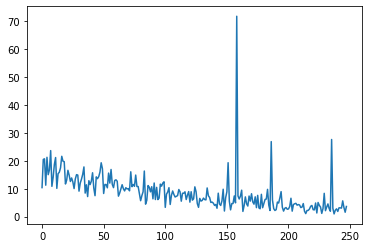

In [6]:
plt.plot(np.sum(zstokes_all[:,:,2],axis=0)[1:-1])
plt.show()




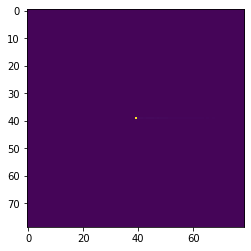

In [7]:
window=40
a=np.mean(co_xy_all,axis=0)[250-window+1:250+window,250-window+1:250+window,0]
b=np.mean(co_xy_all,axis=0)[250-window+1:250+window,250-window+1:250+window,1]-1
c=np.mean(co_xy_all,axis=0)[250-window+1:250+window,250-window+1:250+window,2]
d=np.mean(co_xy_all,axis=0)[250-window+1:250+window,250-window+1:250+window,3]
a[a==0]=1
x=(b**2+c**2+d**2)/a**2
x[0,0]=0
# x[NNxy-1,NNxy-1]=0
# x[NNxy-2,NNxy-2]=0
# 
x=x/x.max()
x[x==1]=0.5
x=(x-x.mean())/x.std()
x=x/x.max()
plt.imshow(x)
# plt.imshow(x[3:-3,3:-3])
plt.show()
